# Replicating opt-SNE

### Preliminaries

In [2]:
import sys 
!{sys.executable} -m pip install flowkit 

In [2]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE
# import FlowCal

In [4]:
file_path = 'data/flow18_annotated.fcs'
# flow_data = FlowCal.io.FCSData(file_path)
flow_data = fk.Sample(file_path)
print("FCS file loaded successfully!")

FCS file loaded successfully!


In [3]:
# Pre-processing data 

sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

fraction_used = 1.0 

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

In [6]:
print(len(features))

1000021


In [4]:
# KLD Tracker 
from openTSNE import callbacks
# Define a custom callback to record KL divergence
class KLDTracker(callbacks.Callback):
    def __init__(self, record_every=10):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        # Record KL divergence at the specified interval
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

## Section 1: Number of Iterations

In [5]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 229.38 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 56.09 seconds


In [6]:
# step 2: define initial embedding 
# init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)
init = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True)

In [7]:
# step 3: construct TSNEEmbedding object 
embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    verbose=True
)

#### total iter: 1000, EE stop: 250

In [11]:
## step 4: EE phase 
kld_tracker_EE = KLDTracker(record_every=5)
flow1000_embedding = embedding.optimize(
    n_iter=250, 
    learning_rate=200, 
    exaggeration=12, 
    momentum=0.5, 
    callbacks= kld_tracker_EE, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 201.7494 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 201.2047 sec
Iteration  150, KL divergence 9.7230, 50 iterations in 201.3122 sec
Iteration  200, KL divergence 9.7230, 50 iterations in 201.1539 sec
Iteration  250, KL divergence 9.7230, 50 iterations in 201.2905 sec
   --> Time elapsed: 1006.71 seconds


In [9]:
# Convert to DataFrame 
# embedding_df = pd.DataFrame(EE250_embedding, columns=['x', 'y'])
# embedding_df['label'] = labels
# Save to CSV
# embedding_df.to_csv('flow18_EE250_new_param.csv', index=False)

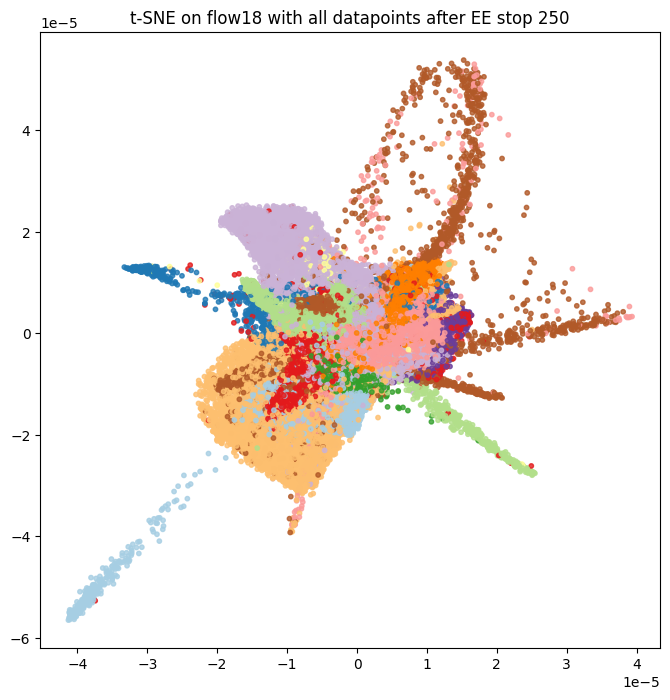

In [12]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints after EE stop 250")
plt.show()

In [13]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed = KLDTracker(record_every=5)

flow1000_embedding = flow1000_embedding.optimize(
    n_iter=750, 
    learning_rate=200, 
    momentum=0.8, 
    callbacks=kld_tracker_embed, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 193.6800 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 193.4501 sec
Iteration  150, KL divergence 9.7229, 50 iterations in 193.4837 sec
Iteration  200, KL divergence 9.7049, 50 iterations in 193.6833 sec
Iteration  250, KL divergence 9.1313, 50 iterations in 194.1505 sec
Iteration  300, KL divergence 8.4981, 50 iterations in 193.8679 sec
Iteration  350, KL divergence 8.1502, 50 iterations in 194.0010 sec
Iteration  400, KL divergence 7.9130, 50 iterations in 194.0945 sec
Iteration  450, KL divergence 7.7324, 50 iterations in 194.0136 sec
Iteration  500, KL divergence 7.5857, 50 iterations in 194.0864 sec
Iteration  550, KL divergence 7.4614, 50 iterations in 193.8262 sec
Iteration  600, KL divergence 7.3530, 50 iterations in 194.1210 sec
Iteration  650, KL divergence 7.2563, 50 iterations in 194.0405 sec
Iteration  700, KL divergence 7.16

In [12]:
# Convert to DataFrame 
# embedding_df = pd.DataFrame(final_embedding_short, columns=['x', 'y'])
# embedding_df['label'] = labels
# Save to CSV
# embedding_df.to_csv('flow18_EE250_1000iter_new_param.csv', index=False)

missing so far: KLD plot (TODO)

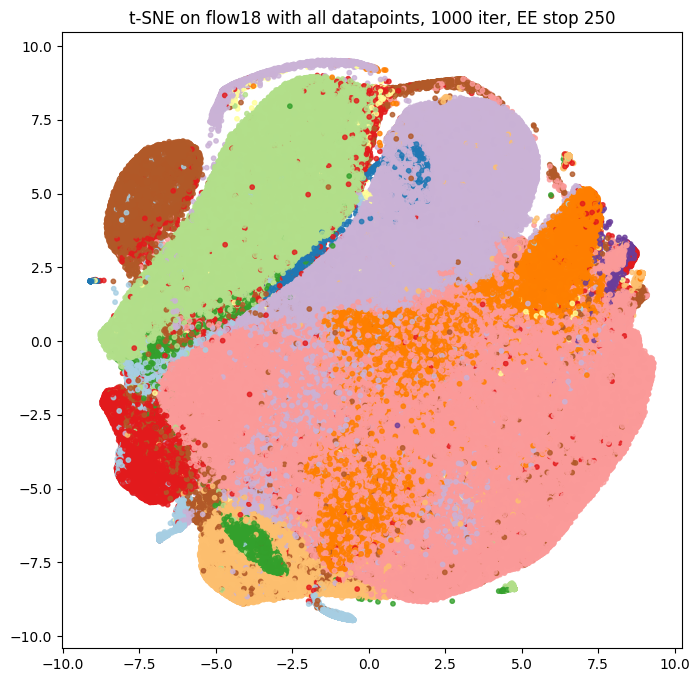

In [14]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints, 1000 iter, EE stop 250")
plt.show()

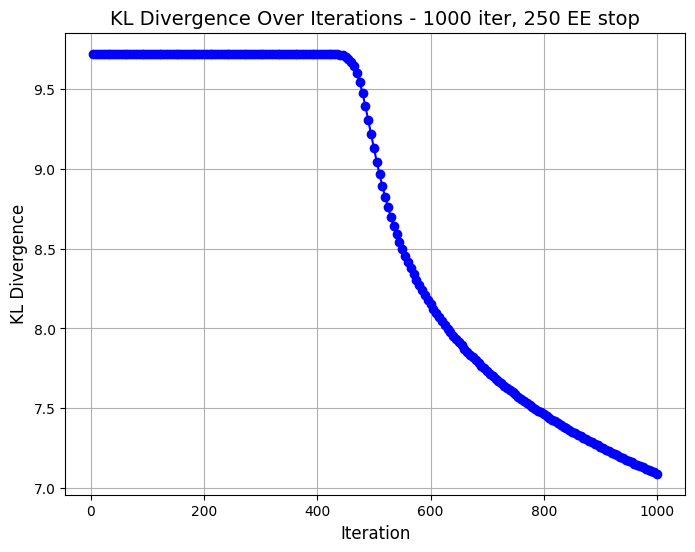

In [15]:
adjusted_divergences = [(iterations + 250, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 1000 iter, 250 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

#### total iter: 3000, EE stop: 750

In [8]:
## step 4: EE phase 
kld_tracker_EE2 = KLDTracker(record_every=5)
flow3000_embedding = embedding.optimize(
    n_iter=750, 
    learning_rate=200, 
    momentum=0.5, 
    exaggeration=12, 
    callbacks= kld_tracker_EE2, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=12.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 192.7203 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 189.9912 sec
Iteration  150, KL divergence 9.7230, 50 iterations in 188.4392 sec
Iteration  200, KL divergence 9.7230, 50 iterations in 188.4228 sec
Iteration  250, KL divergence 9.7230, 50 iterations in 188.3833 sec
Iteration  300, KL divergence 9.7230, 50 iterations in 188.3663 sec
Iteration  350, KL divergence 9.7230, 50 iterations in 188.3366 sec
Iteration  400, KL divergence 9.7230, 50 iterations in 188.3642 sec
Iteration  450, KL divergence 9.7230, 50 iterations in 188.3180 sec
Iteration  500, KL divergence 9.7230, 50 iterations in 188.3689 sec
Iteration  550, KL divergence 9.7228, 50 iterations in 188.3216 sec
Iteration  600, KL divergence 9.7137, 50 iterations in 188.3519 sec
Iteration  650, KL divergence 9.4981, 50 iterations in 188.4078 sec
Iteration  700, KL divergence 9.0

In [10]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(flow3000_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('data/flow3000_afterEE.csv', index=False)

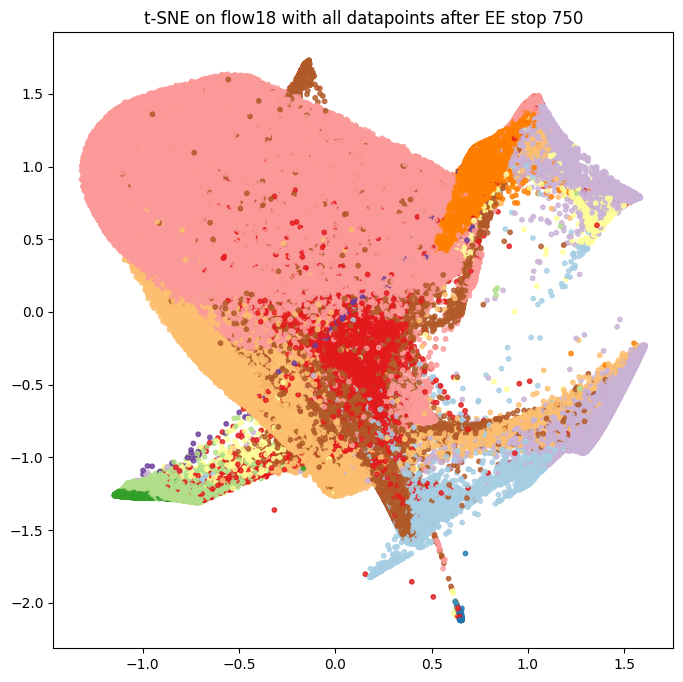

In [11]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow3000_embedding[:, 0], 
    flow3000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints after EE stop 750")
plt.show()

In [ ]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed2 = KLDTracker(record_every=5)

flow3000_embedding = flow3000_embedding.optimize(
    n_iter=2250, 
    learning_rate=200, 
    momentum=0.8, 
    exaggeration=1, 
    callbacks=kld_tracker_embed2, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=200.00 for 2250 iterations...
Iteration   50, KL divergence 8.1184, 50 iterations in 191.5917 sec
Iteration  100, KL divergence 7.7343, 50 iterations in 191.5651 sec
Iteration  150, KL divergence 7.4848, 50 iterations in 191.5490 sec
Iteration  200, KL divergence 7.3022, 50 iterations in 191.5620 sec
Iteration  250, KL divergence 7.1573, 50 iterations in 191.5831 sec
Iteration  300, KL divergence 7.0369, 50 iterations in 191.5843 sec
Iteration  350, KL divergence 6.9340, 50 iterations in 191.5933 sec
Iteration  400, KL divergence 6.8443, 50 iterations in 191.6447 sec
Iteration  450, KL divergence 6.7649, 50 iterations in 191.6349 sec
Iteration  500, KL divergence 6.6937, 50 iterations in 191.6303 sec
Iteration  550, KL divergence 6.6294, 50 iterations in 191.6444 sec
Iteration  600, KL divergence 6.5707, 50 iterations in 191.6453 sec
Iteration  650, KL divergence 6.5169, 50 iterations in 191.6414 sec
Iteration  700, KL divergence 6.4

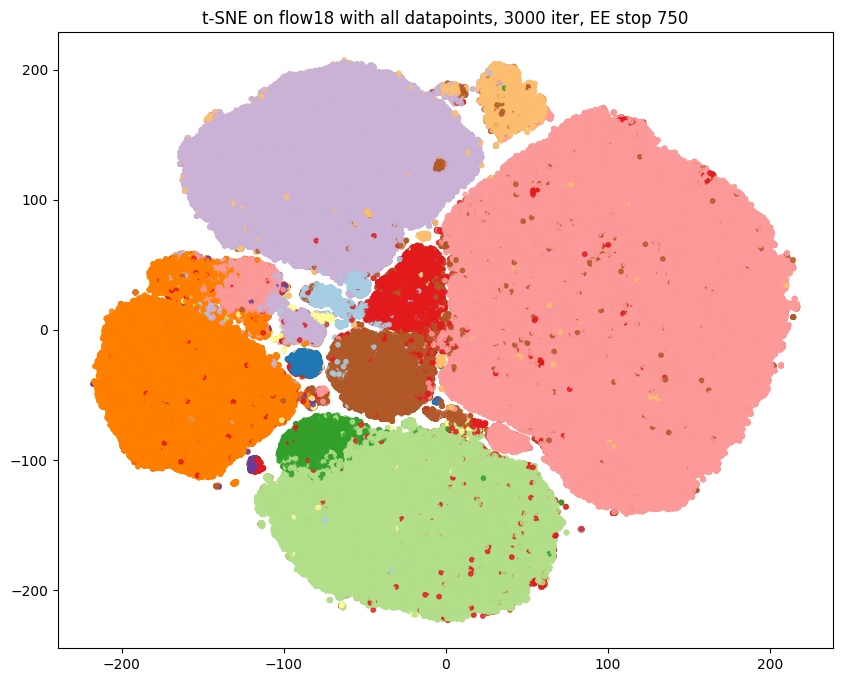

In [21]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow3000_embedding[:, 0], 
    flow3000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints, 3000 iter, EE stop 750")
plt.show()

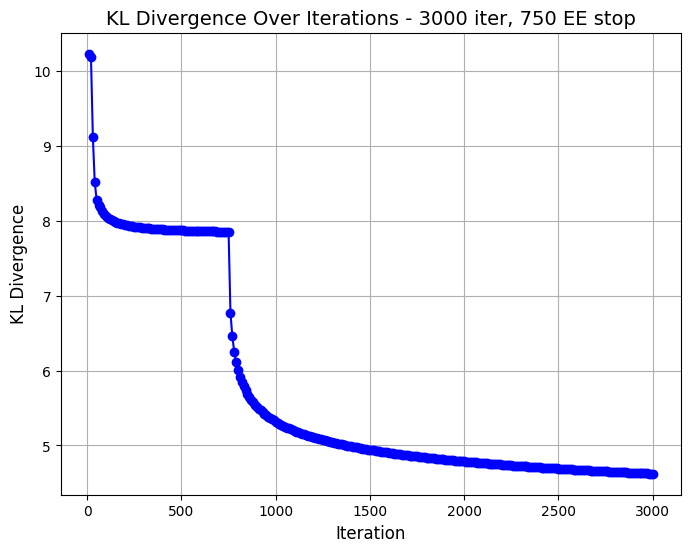

In [26]:
adjusted_divergences = [(iterations + 750, errors) for (iterations, errors) in kld_tracker_embed2.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE2.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 3000 iter, 750 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

In [22]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(final_embedding_long, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE750_3000iter_new_param.csv', index=False)

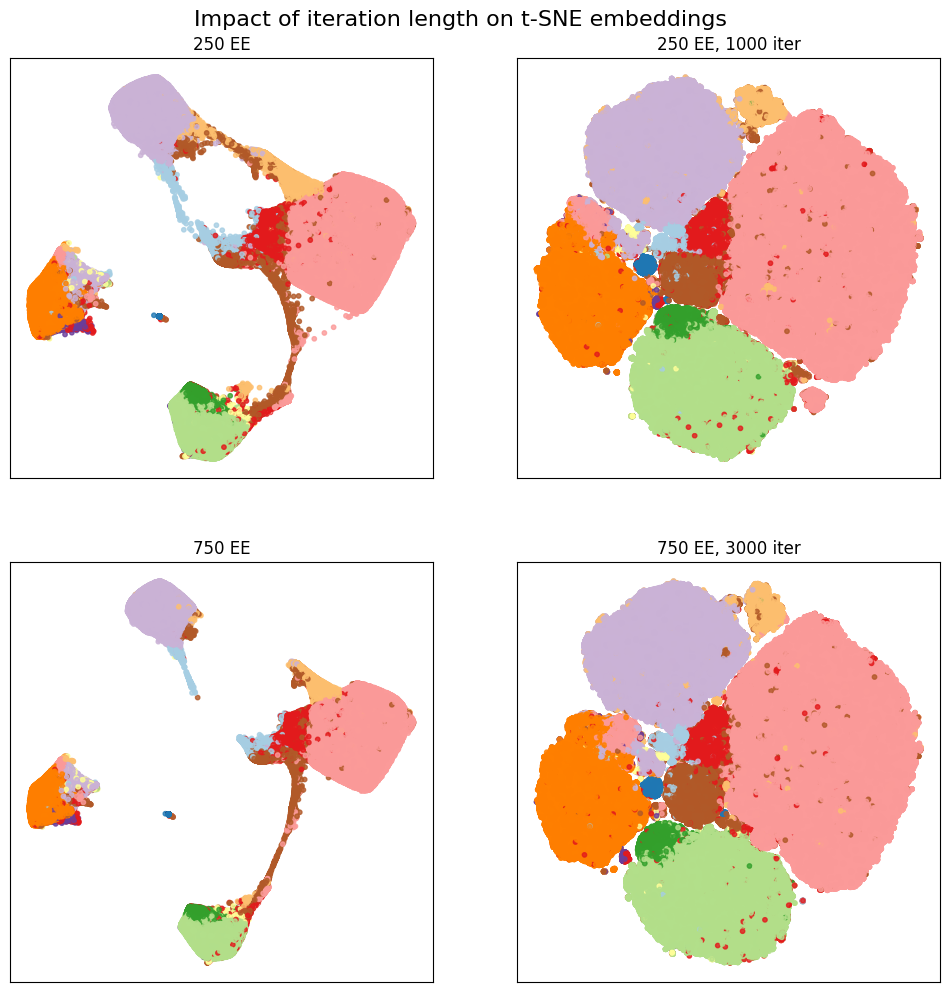

In [ ]:
# List of embeddings
all_embeddings = [EE250_embedding, final_embedding_short, EE750_embedding, final_embedding_long]

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Title for the entire figure
fig.suptitle("Impact of iteration length on t-SNE embeddings", fontsize=16, y=0.92)

# Subtitles for each subplot
subtitles = ["250 EE", "250 EE, 1000 iter", "750 EE", "750 EE, 3000 iter"]

# Plot each embedding in the corresponding subplot
for ax, embedding, subtitle in zip(axes.flat, all_embeddings, subtitles):
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                          c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
    ax.set_xticks([])  # Hide x ticks
    ax.set_yticks([])  # Hide y ticks
    ax.set_title(subtitle, fontsize=12)  # Subtitle for each subplot

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the main title
plt.show()
